### Installing and loading libraries

In [2]:
import os
import pandas as pd
import numpy as np
import json
from pathlib import Path
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import zscore

In [17]:
distinct_colors_14 = ['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231',
                      '#911eb4', '#46f0f0', '#f032e6', '#fffac8', 
                      '#008080', '#e6beff', '#9a6324', '#000000', '#aaffc3']

In [3]:
wd = os.getcwd()

DATA = os.path.join(os.path.sep, str(Path(wd).parents[0]), "data", "processed")
FIGURES = os.path.join(os.path.sep, str(Path(wd).parents[0]), "reports", "figures")

In [5]:
dftype = "reduced"

spec_df = pd.read_pickle(os.path.join(os.path.sep, DATA, 'df_focal_'+dftype+'.pkl'))
embedding_filename = 'basic_UMAP_'+dftype+'_default_params.csv'
embedding = np.loadtxt(os.path.join(os.path.sep, DATA, embedding_filename),delimiter=";")

Setting project, input and output folders.

# Clustering

In [ ]:
from sklearn.mixture import BayesianGaussianMixture

In [15]:
from sklearn.cluster import SpectralClustering
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
import hdbscan
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics import silhouette_score
import scipy
#os.system('pip install scikit-fuzzy')
#import skfuzzy as fuzz

In [8]:
# https://stackoverflow.com/questions/49586742/rand-index-function-clustering-performance-evaluation

def rand_index_score(clusters, classes):
    tp_plus_fp = scipy.special.comb(np.bincount(clusters), 2).sum()
    tp_plus_fn = scipy.special.comb(np.bincount(classes), 2).sum()
    A = np.c_[(clusters, classes)]
    tp = sum(scipy.special.comb(np.bincount(A[A[:, 0] == i, 1]), 2).sum() for i in set(clusters))
    fp = tp_plus_fp - tp
    fn = tp_plus_fn - tp
    tn = scipy.special.comb(len(A), 2) - tp - fp - fn
    return (tp + tn) / (tp + fp + fn + tn)
    
def calc_rand(pred, true):
    classnames, pred = np.unique(pred, return_inverse=True)
    classnames, true = np.unique(true, return_inverse=True)
    return rand_index_score(pred, true)

Brief overview of some clustering methods:
https://scikit-learn.org/stable/modules/clustering.html#overview-of-clustering-methods

Or:
https://hdbscan.readthedocs.io/en/0.8.6/comparing_clustering_algorithms.html

The aim is to cluster the calls into distinct categories based on the UMAP values. I'm also adding duration as a third variable, since it looks like it would really improve clustering.
I try different clustering methods and compare their performance using several evaluation metrics.

In [13]:
true_labels = spec_df.call_lable.values
cluster_df = pd.DataFrame(embedding)

In [10]:
N_CLUST = 7
cluster_df.head(3)

0         1         2
0  7.347082  9.047203  1.046719
1  7.523638  8.182943  1.328811
2  6.742503  8.127052  2.259881

In [ ]:
clusterings_dict = {}

In [23]:
# Cannot set the number of desired clusters in HDBSCAN, thus select min_samples
# so that I hopefully get a similar number of clusters as in original dataset.

# https://hdbscan.readthedocs.io/en/0.8.6/api.html
HDBSCAN = hdbscan.HDBSCAN(
    min_cluster_size=66, #66, # the smallest size we would expect a cluster to be (10 % of dataset size))
    #min_samples=10, # 15, # larger values = more conservative clustering # 10
    cluster_selection_method='eom'
    #cluster_selection_method='leaf'
)
HDBSCAN.fit(cluster_df);
#HDBSCAN.fit(u_embedding);

print("Total: ", len(HDBSCAN.labels_))
print("Number of classes: ",np.max(HDBSCAN.labels_)+1)
print("Unassigned: ",sum(HDBSCAN.labels_==-1), "(", sum(HDBSCAN.labels_==-1)/len(HDBSCAN.labels_), ")")

Total:  6430
Number of classes:  9
Unassigned:  1782 ( 0.2771384136858476 )


# Spectral Clustering

In [16]:
#clustering = SpectralClustering(random_state=2204, affinity='nearest_neighbors', n_neighbors=10).fit(embedding)
clustering = SpectralClustering(random_state=2204).fit(embedding)

In [ ]:
clusterings_dict['Spectral'] = SpectralClustering(random_state=2204).fit(embedding)
clusterings_dict['HDBSCA'] = 


In [18]:
from plot_functions import mara_3Dplot, plotly_viz

In [20]:
mara_3Dplot(embedding[:,0],
            embedding[:,1],
            embedding[:,2],
            clustering.labels_,
            distinct_colors_14,
            outname=None)

In [21]:
adjusted_rand_score(clustering.labels_, true_labels)

0.3825672036287066

In [22]:
calc_rand(clustering.labels_, true_labels)

0.8225108476438533

In [ ]:
from sklearn.cluster import AffinityPropagation
clustering = AffinityPropagation(random_state=2204).fit(embedding)

## HDBSCAN

This is the clustering algorithm that was used in the paper. It's basically a hierarchical clustering algorithm, but the distance matrix is built from the "mutual reachability distance" (distances in sparser regions become larger). In addition, the decision on where to "cut the tree" is based on an evaluation metric. Points can "fall out of clusters" and thus be left unassigned (these are then labelled with -1).

More detailed explanation: https://hdbscan.readthedocs.io/en/latest/how_hdbscan_works.html

In [23]:
# Cannot set the number of desired clusters in HDBSCAN, thus select min_samples
# so that I hopefully get a similar number of clusters as in original dataset.

# https://hdbscan.readthedocs.io/en/0.8.6/api.html
HDBSCAN = hdbscan.HDBSCAN(
    min_cluster_size=66, #66, # the smallest size we would expect a cluster to be (10 % of dataset size))
    #min_samples=10, # 15, # larger values = more conservative clustering # 10
    cluster_selection_method='eom'
    #cluster_selection_method='leaf'
)
HDBSCAN.fit(cluster_df);
#HDBSCAN.fit(u_embedding);

print("Total: ", len(HDBSCAN.labels_))
print("Number of classes: ",np.max(HDBSCAN.labels_)+1)
print("Unassigned: ",sum(HDBSCAN.labels_==-1), "(", sum(HDBSCAN.labels_==-1)/len(HDBSCAN.labels_), ")")

Total:  6430
Number of classes:  9
Unassigned:  1782 ( 0.2771384136858476 )


In [24]:
# Optimal settings as by SIL:

# Cannot set the number of desired clusters in HDBSCAN, thus select min_samples
# so that I hopefully get a similar number of clusters as in original dataset.

# https://hdbscan.readthedocs.io/en/0.8.6/api.html
HDBSCAN = hdbscan.HDBSCAN(
    min_cluster_size=15, #66, # the smallest size we would expect a cluster to be (10 % of dataset size))
    #min_samples=60, # 15, # larger values = more conservative clustering # 10
    cluster_selection_method='eom'
    #cluster_selection_method='leaf'
)
HDBSCAN.fit(cluster_df);
#HDBSCAN.fit(u_embedding);

print("Total: ", len(HDBSCAN.labels_))
print("Number of classes: ",np.max(HDBSCAN.labels_)+1)
print("Unassigned: ",sum(HDBSCAN.labels_==-1), "(", sum(HDBSCAN.labels_==-1)/len(HDBSCAN.labels_), ")")

Total:  6430
Number of classes:  63
Unassigned:  2640 ( 0.4105754276827372 )


In [ ]:
np.save(DATA+'2020-10-21_HDBSCAN_focal.npy', HDBSCAN.labels_)

In [ ]:
df_name

'embedding_denoised_mfcc_delta_full'

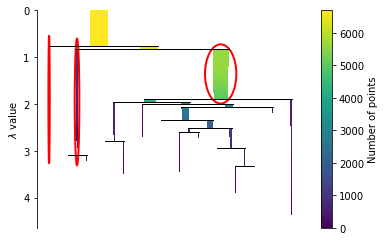

In [ ]:
HDBSCAN.condensed_tree_.plot(select_clusters=True)

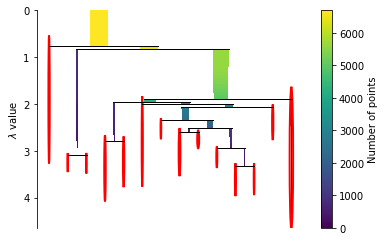

In [ ]:
HDBSCAN.condensed_tree_.plot(select_clusters=True)

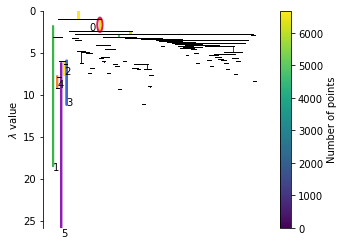

In [ ]:
# 14 distinct colors
fig = plt.figure(figsize=(5,4))
labeltypes = sorted(list(set(HDBSCAN.labels_)))
distinct_colors_14 = ['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231',
                      '#911eb4', '#46f0f0', '#f032e6', '#fffac8', 
                      '#008080', '#e6beff', '#9a6324', '#000000', '#aaffc3']
customPalette = sns.color_palette(distinct_colors_14, n_colors=len(labeltypes))
color_dict = dict(zip(labeltypes, customPalette))

HDBSCAN.condensed_tree_.plot(select_clusters=True,
                             selection_palette=customPalette,
                             label_clusters = True
                             )
plt.savefig(FIGURES+'HDBSCAN_treeplot.png')

In addition to unassigned data, there's also outliers:

In [ ]:
embedding = np.asarray(embedding)

In [ ]:
threshold = pd.Series(HDBSCAN.outlier_scores_).quantile(0.9)
outliers = np.where(HDBSCAN.outlier_scores_ > threshold)[0]

plt.scatter(x=embedding[:,0], y=embedding[:,1], s=50, linewidth=0, c='gray', alpha=0.25)
plt.scatter(x=embedding[outliers,0], y=embedding[outliers,1].T, s=50, linewidth=0, c='red', alpha=0.5)

In [ ]:
outlier_c = np.zeros(len(HDBSCAN.labels_))
outlier_c[outliers] = 1


plot_df = pd.DataFrame(embedding[:,0:3], columns=['UMAP1', 'UMAP2', 'UMAP3'])
plot_df['Size'] = [1] * embedding.shape[0]
plot_df['Outlier'] = outlier_c


fig = px.scatter_3d(plot_df, x='UMAP1', y='UMAP2', z='UMAP3',
                    #width=1000, height=600,       
                    color='Outlier', size='Size', opacity=0.8,
                    width=1000, height=1000
                    )

fig.show()

Check unassigned datapoints (clusterlabel = -1)

In [ ]:
unassigned = np.zeros(len(HDBSCAN.labels_))
unassigned[np.where(HDBSCAN.labels_==-1)[0]] = 1
umap_df['unassigned'] = unassigned

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
fig = px.scatter_3d(plot_df, x='UMAP1', y='UMAP2', z='UMAP3',
                    #width=1000, height=600,       
                    color=unassigned, size='Size', opacity=0.8,
                    width=1000, height=1000
                    )

fig.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
adjusted_rand_score(kmeans.labels_, agglo.labels_)

0.8668127556959623

In [ ]:
calc_rand(kmeans.labels_, agglo.labels_)

0.9676585725532341

## K-Means

In [ ]:
N_CLUST = 8

Very simple clustering based on k nearest neighbors, probably won't do too well on this dataset. More as a comparison to the other clustering algorithms. 

In [ ]:
kmeans = KMeans(n_clusters=N_CLUST, random_state=0).fit(cluster_df)

In [ ]:
kmeans = KMeans(n_clusters=N_CLUST, random_state=0).fit(u_embedding)

In [ ]:
from sklearn.metrics import silhouette_score

In [ ]:
max_clusters = 25
kmeans_eval = np.zeros((max_clusters, 4))

for n_clust in range(1,max_clusters+1):
  kmeans = KMeans(n_clusters=n_clust, random_state=0).fit(cluster_df)
  pred = kmeans.labels_
  kmeans_eval[n_clust-1,0] = n_clust
  kmeans_eval[n_clust-1,1] = adjusted_rand_score(pred, true_labels)
  kmeans_eval[n_clust-1,2] = calc_rand(pred, true_labels)
  if n_clust>1:
    kmeans_eval[n_clust-1,3] = silhouette_score(np.asarray(cluster_df), pred)

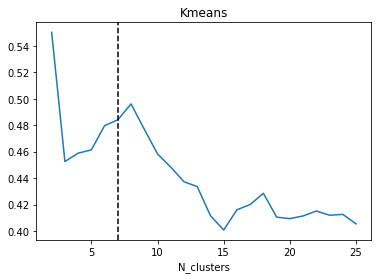

In [ ]:
#sns.set_palette("tab10")
x = kmeans_eval[1:,0]
plt.plot(x,kmeans_eval[1:,3])
plt.xlabel("N_clusters")
plt.axvline(x=7, color="black", linestyle='--')
plt.title('Kmeans')
#plt.show()
plt.savefig(FIGURES+'kmeans_sil.png')

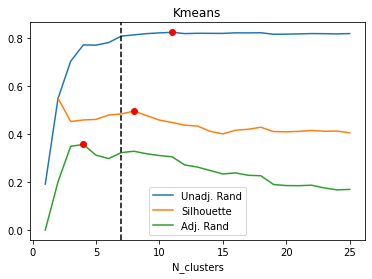

In [ ]:
#sns.set_palette("tab10")
x = kmeans_eval[:,0]
plt.plot(x,kmeans_eval[:,2], label='Unadj. Rand')
plt.plot(x[1:],kmeans_eval[1:,3], label='Silhouette')
plt.plot(x, kmeans_eval[:,1], label='Adj. Rand')

# Add maximums
maxi = np.where(kmeans_eval[:,2]==np.max(kmeans_eval[:,2]))[0][0]
plt.plot(maxi+1, kmeans_eval[maxi,2], 'ro')

maxi = np.where(kmeans_eval[:,3]==np.max(kmeans_eval[2:,3]))[0][0]
plt.plot(maxi+1, kmeans_eval[maxi,3], 'ro')

maxi = np.where(kmeans_eval[:,1]==np.max(kmeans_eval[:,1]))[0][0]
plt.plot(maxi+1, kmeans_eval[maxi,1], 'ro')

plt.xlabel("N_clusters")
plt.axvline(x=7, color="black", linestyle='--')
plt.legend()
plt.title('Kmeans')
#plt.show()
plt.savefig(FIGURES+'kmeans_opti_all.png')

In [ ]:
print("Adj:",round(np.min(kmeans_eval[:,1]),2),"-",round(np.max(kmeans_eval[:,1]),2), " max: ", np.where(kmeans_eval[:,1]==np.max(kmeans_eval[:,1]))[0][0]+1)
print("Unaddj:",round(np.min(kmeans_eval[:,2]),2),"-",round(np.max(kmeans_eval[:,2]),2), " max: ", np.where(kmeans_eval[:,2]==np.max(kmeans_eval[:,2]))[0][0]+1)
print("Sil>3:",round(np.min(kmeans_eval[2:,3]),2),"-",round(np.max(kmeans_eval[2:,3]),2), " max: ", np.where(kmeans_eval[:,3]==np.max(kmeans_eval[2:,3]))[0][0]+1)

Adj: 0.0 - 0.36  max:  4
Unaddj: 0.19 - 0.82  max:  11
Sil>3: 0.4 - 0.5  max:  8


In [ ]:
pd.DataFrame(kmeans_eval)

0         1         2         3
0    1.0  0.000000  0.191683  0.000000
1    2.0  0.200282  0.547759  0.550218
2    3.0  0.349097  0.703741  0.452625
3    4.0  0.356718  0.771944  0.458906
4    5.0  0.312161  0.770963  0.461428
5    6.0  0.297987  0.781928  0.479726
6    7.0  0.322951  0.808890  0.484142
7    8.0  0.328523  0.813885  0.496108
8    9.0  0.317871  0.819132  0.476972
9   10.0  0.310587  0.822192  0.458382
10  11.0  0.305253  0.824477  0.448367
11  12.0  0.271332  0.819231  0.437322
12  13.0  0.262588  0.820528  0.433663
13  14.0  0.248143  0.820271  0.411686
14  15.0  0.233699  0.820036  0.400873
15  16.0  0.238239  0.822385  0.416113
16  17.0  0.228249  0.822097  0.420144
17  18.0  0.226285  0.822661  0.428584
18  19.0  0.189834  0.816391  0.410603
19  20.0  0.185333  0.816994  0.409473
20  21.0  0.184897  0.817903  0.411499
21  22.0  0.186908  0.819336  0.415228
22  23.0  0.175398  0.818865  0.412042
23  24.0  0.167490  0.817885  0.412680
24  25.0  0.169293  0.819349  0.405524

In [ ]:
eval_dict= {}
eval_dict['kmeans'] = kmeans_eval

Visualize best performing:

In [ ]:
# Best performing:
kmeans = KMeans(n_clusters=np.where(kmeans_eval[:,3]==np.max(kmeans_eval[2:,3]))[0][0]+1, random_state=0).fit(cluster_df)

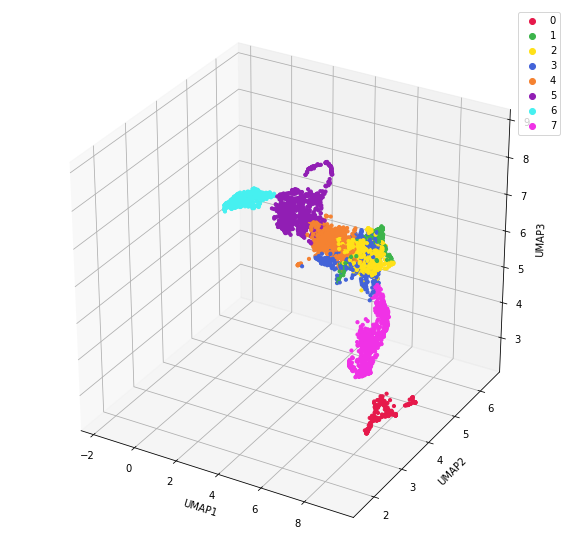

In [ ]:
embedding = np.asarray(embedding)
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

scat_labels = kmeans.labels_
scat_labels = kmeans_mod
labeltypes = sorted(list(set(scat_labels)))

# 14 distinct colors
customPalette = sns.color_palette(distinct_colors_14[1:], n_colors=len(labeltypes))
color_dict = dict(zip(labeltypes, customPalette))

for key in color_dict.keys():
  color_dict[key] = color_dict[key] +(1,)
color_dict[-1] = (0.2,0.2,0.2,0.1)

c = [color_dict[val] for val in scat_labels]

Axes3D.scatter(ax,
               #xs = umap_df.UMAP1.values,
               #ys = umap_df.UMAP2.values,
               #zs= umap_df.duration_s.values,
               #xs = cluster_df.UMAP1.values,
               #ys = cluster_df.UMAP2.values,
               xs = embedding[:,0],
               ys = embedding[:,1],
               zs = embedding[:,2],
               #zs= df.duration_s.values,
               #zs= cluster_df.UMAP3.values,
               zdir='z',
               s=10,
               label = c,
               c=c,
               depthshade=False)


ax.set_xlabel('UMAP1')
ax.set_ylabel('UMAP2')
ax.set_zlabel('UMAP3')

# Legend
scatters = []
for label in labeltypes:
  scatters.append(matplotlib.lines.Line2D([0],[0], linestyle="none", c=color_dict[label], marker = 'o'))
ax.legend(scatters, labeltypes, numpoints = 1)

plt.savefig(FIGURES+'2020-10-21_clustering_focal_kmeans')

In [ ]:
def update(i, fig, ax):
    ax.view_init(elev=20., azim=i)
    return fig, ax
 
anim = FuncAnimation(fig, update, frames=np.arange(0, 360, 2), repeat=True, fargs=(fig, ax))

# Save animation
anim.save(FIGURES+'2020-10-21_clustering_focal_kmeans.gif', dpi=80, writer='pillow', fps=12)

# Play animation
# this is the part which makes it work on Colab
#rc('animation', html='jshtml')
#anim

## Fuzzy c-means

In [ ]:
os.system('pip install scikit-fuzzy')
import skfuzzy as fuzz

In [ ]:
ncenters = 7
cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(embedding.T, ncenters, 2, error=0.005, maxiter=1000, init=None)
#(data, c, m, error, maxiter, init=None, seed=None)[source]

In [ ]:
embedding

0         1         2  ...         7         8         9
0     5.299764  6.417554  4.202350  ...  2.581645  3.845777  2.846862
1     6.663779  7.219666  3.152430  ...  2.527444  4.023995  2.729822
2     6.665429  6.820063  4.278993  ...  3.022829  4.242816  2.590861
3     6.488270  7.500552  3.221153  ...  2.565979  4.022411  2.766559
4     6.717881  7.241799  2.998840  ...  2.388643  3.939341  2.841877
...        ...       ...       ...  ...       ...       ...       ...
6682  4.380852  6.640742  4.665015  ...  2.784216  3.901149  2.732154
6683  7.741432  6.654871  4.756604  ...  2.906879  4.046004  3.105088
6684  5.221426  7.338924  4.662949  ...  2.303291  3.607582  3.376875
6685  4.061265  7.423884  4.847203  ...  2.518864  3.678751  3.108299
6686  6.684179  6.198024  4.346596  ...  2.420089  3.775421  3.178828

[6687 rows x 10 columns]

In [ ]:
cluster_membership = np.argmax(u, axis=0)

In [ ]:
reducer = umap.UMAP(low_memory=True, n_components = 3, min_dist=0)
u_embedding = reducer.fit_transform(np.transpose(u))

In [ ]:
u_embedding.shape

(6687, 3)

In [ ]:
embedding = np.asarray(embedding)
# Plot assigned clusters, for each data point in training set
cluster_membership = np.argmax(u, axis=0)

#t = np.linspace(0, 10, 50)
x, y, z = u_embedding[:,0], u_embedding[:,1], u_embedding[:,2] #np.asarray(umap_df.duration_s.values) #embedding[:,2]
scat_labels = true_labels
#scat_labels = cluster_membership
labeltypes = sorted(list(set(scat_labels)))
# makes colors same as AVGN visualization
pal = sns.color_palette("Set2", n_colors=len(labeltypes))
color_dict = dict(zip(labeltypes, pal))
c = [color_dict[val] for val in scat_labels]

fig = go.Figure(data=[go.Scatter3d(x=x, y=y, z=z,
                                   mode='markers',
                                   hovertext = umap_df.call_lable.values, #+ " (" +umap_df.Name.values+")",
                                   marker=dict(
                                       size=4,
                                       color=c,                # set color to an array/list of desired values
                                       #colorscale='Viridis',   # choose a colorscale
                                       opacity=0.8
                                       ))])

fig.update_layout(scene = dict(
                    xaxis_title='UMAP1',
                    yaxis_title='UMAP2',
                    zaxis_title='UMAP3'),
                    #zaxis_title='Duration (s)'),
                    width=700,
                    margin=dict(r=20, b=10, l=10, t=10))

fig.show()

## Agglomerative clustering

Simple clustering, try different distance metrics (euclidean, cityblock...) and linkage methods (average, ward...).

In [ ]:
aggl_clusterer = AgglomerativeClustering(n_clusters=N_CLUST,
                                         linkage="average", affinity="euclidean")
aggl_clusterer.fit(cluster_df)

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
                        connectivity=None, distance_threshold=None,
                        linkage='average', memory=None, n_clusters=8)

In [ ]:
aggl_clusterer.fit(u_embedding)

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
                        connectivity=None, distance_threshold=None,
                        linkage='average', memory=None, n_clusters=7)

In [ ]:
max_clusters = 25
eval = np.zeros((max_clusters, 4))

for n_clust in range(1,max_clusters+1):
  agglo = AgglomerativeClustering(n_clusters=n_clust,linkage="average", affinity="euclidean")
  agglo.fit(cluster_df)
  pred = agglo.labels_
  eval[n_clust-1,0] = n_clust
  eval[n_clust-1,1] = adjusted_rand_score(pred, true_labels)
  eval[n_clust-1,2] = calc_rand(pred, true_labels)
  if n_clust>1:
    eval[n_clust-1,3] = silhouette_score(np.asarray(cluster_df), pred)

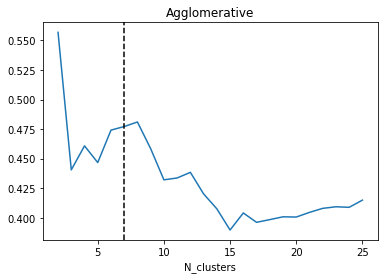

In [ ]:
x = eval[1:,0]
plt.plot(x,eval[1:,3])
plt.xlabel("N_clusters")
plt.axvline(x=7, color="black", linestyle='--')
plt.title('Agglomerative')
#plt.show()
plt.savefig(FIGURES+'aggl_sil.png')

In [ ]:
x = eval[:,0]
plt.plot(x,eval[:,2], label='Unadj. Rand')
plt.plot(x[1:],eval[1:,3], label='Silhouette')
plt.plot(x, eval[:,1], label='Adj. Rand')
plt.xlabel("N_clusters")

# Add maximums
maxi = np.where(eval[:,2]==np.max(eval[:,2]))[0][0]
plt.plot(maxi+1, eval[maxi,2], 'ro')

maxi = np.where(eval[:,3]==np.max(eval[2:,3]))[0][0]
plt.plot(maxi+1, eval[maxi,3], 'ro')

maxi = np.where(eval[:,1]==np.max(eval[:,1]))[0][0]
plt.plot(maxi+1, eval[maxi,1], 'ro')

plt.axvline(x=7, color="black", linestyle='--')
plt.legend()
plt.title('Aggl. Clustering')
#plt.show()
plt.savefig(FIGURES+'agglo_opti_all.png')

In [ ]:
x = eval[:,0]
plt.plot(x, eval[:,1], label='Adj. Rand')
plt.plot(x,eval[:,2], label='Unadj. Rand')
plt.xlabel("N_clusters")
plt.axvline(x=7, color="black", linestyle='--')
plt.legend()
plt.title('Aggl. Clustering')
#plt.show()
plt.savefig(FIGURES+'agglo_opti.png')

In [ ]:
print("Adj:",round(np.min(eval[:,1]),2),"-",round(np.max(eval[:,1]),2), " max: ", np.where(eval[:,1]==np.max(eval[:,1]))[0][0]+1)
print("Unaddj:",round(np.min(eval[:,2]),2),"-",round(np.max(eval[:,2]),2), " max: ", np.where(eval[:,2]==np.max(eval[:,2]))[0][0]+1)
print("Sil>3:",round(np.min(eval[2:,3]),2),"-",round(np.max(eval[2:,3]),2), " max: ", np.where(eval[:,3]==np.max(eval[2:,3]))[0][0]+1)

Adj: 0.0 - 0.34  max:  4
Unaddj: 0.19 - 0.83  max:  18
Sil>3: 0.39 - 0.48  max:  8


In [ ]:
eval_dict['agglo'] = eval

In [ ]:
# Best performing:
agglo = AgglomerativeClustering(n_clusters=8,linkage="average", affinity="euclidean")
agglo.fit(cluster_df)

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
                        connectivity=None, distance_threshold=None,
                        linkage='average', memory=None, n_clusters=8)

In [ ]:
embedding = np.asarray(embedding)
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

#scat_labels = agglo.labels_
scat_labels = agglo_mod
labeltypes = sorted(list(set(scat_labels)))

# 14 distinct colors
customPalette = sns.color_palette(distinct_colors_14[1:], n_colors=len(labeltypes))
color_dict = dict(zip(labeltypes, customPalette))

for key in color_dict.keys():
  color_dict[key] = color_dict[key] +(1,)
color_dict[-1] = (0.2,0.2,0.2,0.1)

c = [color_dict[val] for val in scat_labels]

Axes3D.scatter(ax,
               #xs = umap_df.UMAP1.values,
               #ys = umap_df.UMAP2.values,
               #zs= umap_df.duration_s.values,
               #xs = cluster_df.UMAP1.values,
               #ys = cluster_df.UMAP2.values,
               xs = embedding[:,0],
               ys = embedding[:,1],
               zs = embedding[:,2],
               #zs= df.duration_s.values,
               #zs= cluster_df.UMAP3.values,
               zdir='z',
               s=10,
               label = c,
               c=c,
               depthshade=False)


ax.set_xlabel('UMAP1')
ax.set_ylabel('UMAP2')
ax.set_zlabel('UMAP3')

# Legend
scatters = []
for label in labeltypes:
  scatters.append(matplotlib.lines.Line2D([0],[0], linestyle="none", c=color_dict[label], marker = 'o'))
ax.legend(scatters, labeltypes, numpoints = 1)
plt.savefig(FIGURES+'2020-10-21_clustering_focal_agglo')

In [ ]:
def update(i, fig, ax):
    ax.view_init(elev=20., azim=i)
    return fig, ax
 
anim = FuncAnimation(fig, update, frames=np.arange(0, 360, 2), repeat=True, fargs=(fig, ax))

# Save animation
anim.save(FIGURES+'2020-10-21_clustering_focal_agglo.gif', dpi=80, writer='pillow', fps=12)

# Play animation
# this is the part which makes it work on Colab
#rc('animation', html='jshtml')
#anim

## GMM

In [ ]:
dpgmm = BayesianGaussianMixture(n_components=7,weight_concentration_prior=0.01,covariance_type='full').fit(embedding)
gmm = dpgmm.predict(embedding) # res
set(gmm)

{0, 1, 2, 3, 4, 5, 6}

In [ ]:
max_clusters = 25
gmm_eval = np.zeros((max_clusters, 4))

for n_clust in range(1,max_clusters+1):
  dpgmm = BayesianGaussianMixture(n_components=n_clust,weight_concentration_prior=0.01,covariance_type='full').fit(np.asarray(cluster_df))
  pred = dpgmm.predict(np.asarray(cluster_df)) # res
  gmm_eval[n_clust-1,0] = n_clust
  gmm_eval[n_clust-1,1] = adjusted_rand_score(pred, true_labels)
  gmm_eval[n_clust-1,2] = calc_rand(pred, true_labels)
  if n_clust>1:
    gmm_eval[n_clust-1,3] = silhouette_score(np.asarray(cluster_df), pred)

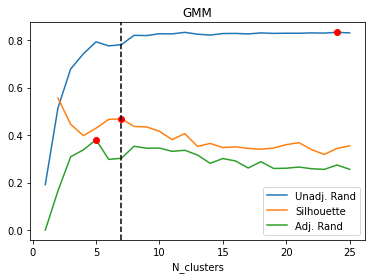

In [ ]:
#sns.set_palette("tab10")
x = gmm_eval[:,0]
plt.plot(x,gmm_eval[:,2], label='Unadj. Rand')
plt.plot(x[1:],gmm_eval[1:,3], label='Silhouette')
plt.plot(x, gmm_eval[:,1], label='Adj. Rand')

# Add maximums
maxi = np.where(gmm_eval[:,2]==np.max(gmm_eval[:,2]))[0][0]
plt.plot(maxi+1, gmm_eval[maxi,2], 'ro')

maxi = np.where(gmm_eval[:,3]==np.max(gmm_eval[2:,3]))[0][0]
plt.plot(maxi+1, gmm_eval[maxi,3], 'ro')

maxi = np.where(gmm_eval[:,1]==np.max(gmm_eval[:,1]))[0][0]
plt.plot(maxi+1, gmm_eval[maxi,1], 'ro')


plt.xlabel("N_clusters")
plt.axvline(x=7, color="black", linestyle='--')
plt.legend()
plt.title('GMM')
#plt.show()
plt.savefig(FIGURES+'gmm_opti_all.png')


In [ ]:
eval_dict['gmm'] = gmm_eval

In [ ]:
print("Adj:",round(np.min(gmm_eval[:,1]),2),"-",round(np.max(gmm_eval[:,1]),2), " max: ", np.where(gmm_eval[:,1]==np.max(gmm_eval[:,1]))[0][0]+1)
print("Unaddj:",round(np.min(gmm_eval[:,2]),2),"-",round(np.max(gmm_eval[:,2]),2), " max: ", np.where(gmm_eval[:,2]==np.max(gmm_eval[:,2]))[0][0]+1)
print("Sil>3:",round(np.min(gmm_eval[2:,3]),2),"-",round(np.max(gmm_eval[2:,3]),2), " max: ", np.where(gmm_eval[:,3]==np.max(gmm_eval[2:,3]))[0][0]+1)

Adj: 0.0 - 0.38  max:  5
Unaddj: 0.19 - 0.83  max:  24
Sil>3: 0.32 - 0.47  max:  7


In [ ]:
dpgmm = BayesianGaussianMixture(n_components=np.where(gmm_eval[:,3]==np.max(gmm_eval[2:,3]))[0][0]+1,weight_concentration_prior=0.01,covariance_type='full').fit(np.asarray(cluster_df))
pred = dpgmm.predict(np.asarray(cluster_df)) # res

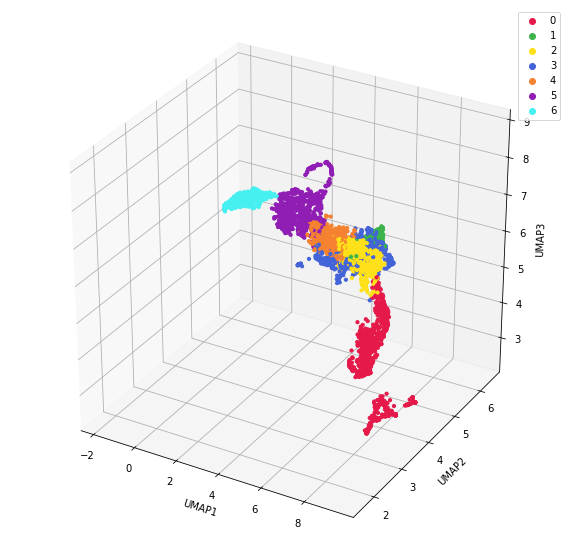

In [ ]:
embedding = np.asarray(embedding)
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

#scat_labels = pred
scat_labels = gmm_mod
labeltypes = sorted(list(set(scat_labels)))

# 14 distinct colors
customPalette = sns.color_palette(distinct_colors_14[1:], n_colors=len(labeltypes))
color_dict = dict(zip(labeltypes, customPalette))

for key in color_dict.keys():
  color_dict[key] = color_dict[key] +(1,)
color_dict[-1] = (0.2,0.2,0.2,0.1)

c = [color_dict[val] for val in scat_labels]

Axes3D.scatter(ax,
               #xs = umap_df.UMAP1.values,
               #ys = umap_df.UMAP2.values,
               #zs= umap_df.duration_s.values,
               #xs = cluster_df.UMAP1.values,
               #ys = cluster_df.UMAP2.values,
               xs = embedding[:,0],
               ys = embedding[:,1],
               zs = embedding[:,2],
               #zs= df.duration_s.values,
               #zs= cluster_df.UMAP3.values,
               zdir='z',
               s=10,
               label = c,
               c=c,
               depthshade=False)


ax.set_xlabel('UMAP1')
ax.set_ylabel('UMAP2')
ax.set_zlabel('UMAP3')

# Legend
scatters = []
for label in labeltypes:
  scatters.append(matplotlib.lines.Line2D([0],[0], linestyle="none", c=color_dict[label], marker = 'o'))
ax.legend(scatters, labeltypes, numpoints = 1)

plt.savefig(FIGURES+'2020-10-21_clustering_focal_gmm')

In [ ]:
def update(i, fig, ax):
    ax.view_init(elev=20., azim=i)
    return fig, ax
 
anim = FuncAnimation(fig, update, frames=np.arange(0, 360, 2), repeat=True, fargs=(fig, ax))

# Save animation
anim.save(FIGURES+'2020-10-21_clustering_focal_gmm.gif', dpi=80, writer='pillow', fps=12)

# Play animation
# this is the part which makes it work on Colab
#rc('animation', html='jshtml')
#anim

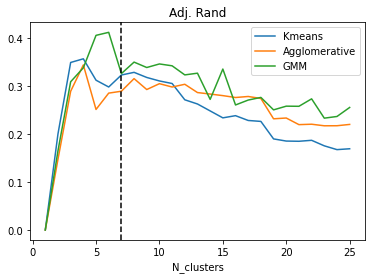

In [ ]:
x = eval[:,0]
plt.plot(x, eval_dict['kmeans'][:,1], label='Kmeans')
plt.plot(x, eval_dict['agglo'][:,1], label='Agglomerative')
plt.plot(x, eval_dict['gmm'][:,1], label='GMM')
plt.xlabel("N_clusters")
plt.axvline(x=7, color="black", linestyle='--')
plt.legend()
plt.title('Adj. Rand')
plt.savefig(FIGURES+'adjR_opti.png')

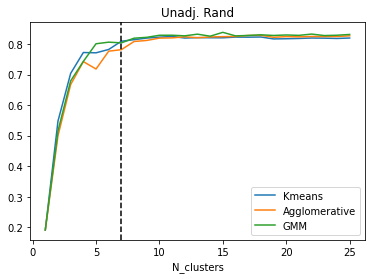

In [ ]:
#x = eval[:,0]
plt.plot(x, eval_dict['kmeans'][:,2], label='Kmeans')
plt.plot(x, eval_dict['agglo'][:,2], label='Agglomerative')
plt.plot(x, eval_dict['gmm'][:,2], label='GMM')
plt.xlabel("N_clusters")
plt.axvline(x=7, color="black", linestyle='--')
plt.legend()
plt.title('Unadj. Rand')
plt.savefig(FIGURES+'unadjR_opti.png')

## Evaluation




Using different evaluation metrics to compare the resulting clustering against the ground truth.

In [ ]:
clusterings = {"HDBSCAN": HDBSCAN, 
               "KMeans": kmeans, 
               "Aggl_Euclid": aggl_clusterer}


In [8]:
# For HDBSCAN, need to remove unassigned datapoints
unassigned = np.zeros(len(HDBSCAN.labels_))
unassigned[np.where(HDBSCAN.labels_==-1)[0]] = 1
assigned = [False if x==1 else True for x in unassigned]

HDB_true_labels = true_labels[assigned]
HDB_pred_labels = HDBSCAN.labels_[assigned]

### Adjusted Rand index

https://scikit-learn.org/stable/modules/clustering.html#adjusted-rand-score

In [ ]:
for cl in clusterings.keys():
  if(cl=="HDBSCAN"):
    print(cl,"(w/o -1):", round(adjusted_rand_score(HDB_pred_labels, HDB_true_labels),2), "( ", round(calc_rand(HDB_pred_labels, HDB_true_labels),2), ")")
  print(cl,":", round(adjusted_rand_score(clusterings[cl].labels_, true_labels),2), "( ", round(calc_rand(clusterings[cl].labels_, true_labels),2), ")")

HDBSCAN (w/o -1): 0.39 (  0.84 )
HDBSCAN : 0.06 (  0.66 )
KMeans : 0.32 (  0.81 )
Aggl_Euclid : 0.29 (  0.78 )


In [ ]:
adjusted_rand_score(kmeans.labels_, aggl_clusterer.labels_)

0.7293104924100051

In [9]:
adjusted_rand_score(HDB_pred_labels, HDB_true_labels)

0.11825422845226648

In [10]:
calc_rand(HDB_pred_labels, HDB_true_labels)

0.4372481311598786

In [12]:
silhouette_score(embedding, HDB_pred_labels)

0.16092288

In [ ]:
true_labels = umap_df.call_lable.values
adjusted_rand_score(res, true_labels)

0.33515384665481807

### Unadjusted Rand

In [ ]:
import scipy

In [ ]:
# https://stackoverflow.com/questions/49586742/rand-index-function-clustering-performance-evaluation

def rand_index_score(clusters, classes):
    tp_plus_fp = scipy.special.comb(np.bincount(clusters), 2).sum()
    tp_plus_fn = scipy.special.comb(np.bincount(classes), 2).sum()
    A = np.c_[(clusters, classes)]
    tp = sum(scipy.special.comb(np.bincount(A[A[:, 0] == i, 1]), 2).sum() for i in set(clusters))
    fp = tp_plus_fp - tp
    fn = tp_plus_fn - tp
    tn = scipy.special.comb(len(A), 2) - tp - fp - fn
    return (tp + tn) / (tp + fp + fn + tn)
    
def calc_rand(pred, true):
  classnames, pred = np.unique(pred, return_inverse=True)
  classnames, true = np.unique(true, return_inverse=True)
  return rand_index_score(pred, true)

In [ ]:
calc_rand(HDB_pred_labels, HDB_true_labels)

0.8426227636242032

### Adjusted mutual information score

In [ ]:
for cl in clusterings.keys():
  if(cl=="HDBSCAN"):
    print(cl,"(w/o -1):", adjusted_rand_score(HDB_pred_labels, HDB_true_labels))
  print(cl,":", metrics.adjusted_mutual_info_score(clusterings[cl].labels_, true_labels))

HDBSCAN (w/o -1): 0.034588635805066895
HDBSCAN : 0.13731435714579082
KMeans : 0.3702432232471313
Aggl_Euclid : 0.3647816882537414


In [ ]:
metrics.adjusted_mutual_info_score(aggl_clusterer.labels_, true_labels)

0.3488966391981895

### Compare against random
Just to double-check

In [ ]:
random_assignment = np.random.randint(0, 8, size=(len(true_labels), ))

In [ ]:
for cl in clusterings.keys():
  print(cl,":", adjusted_rand_score(clusterings[cl].labels_, random_assignment))
for cl in clusterings.keys():
  print(cl,":", metrics.adjusted_mutual_info_score(clusterings[cl].labels_, random_assignment))

HDBSCAN : -0.00148735995588718
KMeans : 0.000952395976263719
Aggl_Euclid : -0.00028964932218638635
Aggl_City : 0.00014366126949008845
Aggl_Ward : 0.0014041331031844487
HDBSCAN : -0.002069436590455159
KMeans : 0.0012514822718355304
Aggl_Euclid : -2.366572680243078e-05
Aggl_City : 0.00022876840970089717
Aggl_Ward : 0.0019151573455251552


## Visualization

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.legend import Legend
from matplotlib.animation import FuncAnimation
from matplotlib import animation, rc, gridspec
import matplotlib
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import timeit
import time
from collections import defaultdict

# https://sashamaps.net/docs/resources/20-colors/

distinct_colors_22 = ['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', 
                      '#911eb4', '#46f0f0', '#f032e6', '#bcf60c', '#fabebe', 
                      '#008080', '#e6beff', '#9a6324', '#fffac8', '#800000', 
                      '#aaffc3', '#808000', '#ffd8b1', '#000075', '#808080', 
                      '#ffffff', '#000000']
distinct_colors_14 = ['#ffffff', 
                      '#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231',
                      '#911eb4', '#46f0f0', '#f032e6', '#fffac8', 
                      '#008080', '#e6beff', '#9a6324', '#000000', '#aaffc3']

In [ ]:
sns.color_palette(distinct_colors_22)

[(0.9019607843137255, 0.09803921568627451, 0.29411764705882354),
 (0.23529411764705882, 0.7058823529411765, 0.29411764705882354),
 (1.0, 0.8823529411764706, 0.09803921568627451),
 (0.2627450980392157, 0.38823529411764707, 0.8470588235294118),
 (0.9607843137254902, 0.5098039215686274, 0.19215686274509805),
 (0.5686274509803921, 0.11764705882352941, 0.7058823529411765),
 (0.27450980392156865, 0.9411764705882353, 0.9411764705882353),
 (0.9411764705882353, 0.19607843137254902, 0.9019607843137255),
 (0.7372549019607844, 0.9647058823529412, 0.047058823529411764),
 (0.9803921568627451, 0.7450980392156863, 0.7450980392156863),
 (0.0, 0.5019607843137255, 0.5019607843137255),
 (0.9019607843137255, 0.7450980392156863, 1.0),
 (0.6039215686274509, 0.38823529411764707, 0.1411764705882353),
 (1.0, 0.9803921568627451, 0.7843137254901961),
 (0.5019607843137255, 0.0, 0.0),
 (0.6666666666666666, 1.0, 0.7647058823529411),
 (0.5019607843137255, 0.5019607843137255, 0.0),
 (1.0, 0.8470588235294118, 0.6941176470588235),
 (0.0, 0.0, 0.4588235294117647),
 (0.5019607843137255, 0.5019607843137255, 0.5019607843137255),
 (1.0, 1.0, 1.0),
 (0.0, 0.0, 0.0)]

In [ ]:
sns.color_palette(distinct_colors_14, n_colors=len(labeltypes))

[(1.0, 1.0, 1.0),
 (0.9019607843137255, 0.09803921568627451, 0.29411764705882354),
 (0.23529411764705882, 0.7058823529411765, 0.29411764705882354),
 (1.0, 0.8823529411764706, 0.09803921568627451),
 (0.2627450980392157, 0.38823529411764707, 0.8470588235294118),
 (0.9607843137254902, 0.5098039215686274, 0.19215686274509805),
 (0.5686274509803921, 0.11764705882352941, 0.7058823529411765),
 (0.27450980392156865, 0.9411764705882353, 0.9411764705882353),
 (0.9411764705882353, 0.19607843137254902, 0.9019607843137255),
 (1.0, 0.9803921568627451, 0.7843137254901961),
 (0.0, 0.5019607843137255, 0.5019607843137255),
 (0.9019607843137255, 0.7450980392156863, 1.0),
 (0.6039215686274509, 0.38823529411764707, 0.1411764705882353),
 (0.0, 0.0, 0.0),
 (0.6666666666666666, 1.0, 0.7647058823529411)]

In [ ]:
embedding = np.asarray(embedding)
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

#scat_labels = umap_df.call_lable.values
#scat_labels = kmeans.labels_
#scat_labels = aggl_clusterer.labels_
scat_labels = HDBSCAN.labels_
#scat_labels = res
#scat_labels = umap_df[clustering].values
labeltypes = sorted(list(set(scat_labels)))

# 14 distinct colors
customPalette = sns.color_palette(distinct_colors_14, n_colors=len(labeltypes))
color_dict = dict(zip(labeltypes, customPalette))

for key in color_dict.keys():
  color_dict[key] = color_dict[key] +(1,)
color_dict[-1] = (0.2,0.2,0.2,0.1)

c = [color_dict[val] for val in scat_labels]

Axes3D.scatter(ax,
               #xs = umap_df.UMAP1.values,
               #ys = umap_df.UMAP2.values,
               #zs= umap_df.duration_s.values,
               #xs = cluster_df.UMAP1.values,
               #ys = cluster_df.UMAP2.values,
               xs = embedding[:,0],
               ys = embedding[:,1],
               zs = embedding[:,2],
               #zs= df.duration_s.values,
               #zs= cluster_df.UMAP3.values,
               zdir='z',
               s=10,
               label = c,
               c=c,
               depthshade=False)


ax.set_xlabel('UMAP1')
ax.set_ylabel('UMAP2')
ax.set_zlabel('UMAP3')

# Legend
scatters = []
for label in labeltypes:
  scatters.append(matplotlib.lines.Line2D([0],[0], linestyle="none", c=color_dict[label], marker = 'o'))
ax.legend(scatters, labeltypes, numpoints = 1)

plt.savefig(FIGURES+'2020-10-20_clustering_focal_HDBSCAN_eom')

In [ ]:
def update(i, fig, ax):
    ax.view_init(elev=20., azim=i)
    return fig, ax
 
anim = FuncAnimation(fig, update, frames=np.arange(0, 360, 2), repeat=True, fargs=(fig, ax))

# Save animation
anim.save(FIGURES+'Melspec_HDBSCAN_focal.gif', dpi=80, writer='pillow', fps=12)

# Play animation
# this is the part which makes it work on Colab
#rc('animation', html='jshtml')
#anim

In [ ]:
import plotly.express as px
import plotly.graph_objects as go

In [ ]:
plot_df = pd.DataFrame(np.column_stack((embedding, 
                                        spec_df.duration_s.values,
                                        spec_df.call_lable.values,
                                        HDBSCAN.labels_,
                                        kmeans.labels_,
                                        aggl_clusterer.labels_)), 
                       columns=['UMAP1', 'UMAP2', 'Duration', 'Label', 'HDBSCAN', 'KMeans', 'Agglo'])
plot_df['Size'] = [0.01]*plot_df.shape[0]

In [ ]:
plot_df = umap_df
plot_df['Agglo'] = aggl_clusterer.labels_
plot_df['Size'] = [0.01]*plot_df.shape[0]

In [ ]:
fig = px.scatter_3d(plot_df, x='UMAP1', y='UMAP2', z='Duration',
                    #width=1000, height=600,       
                    color='Agglo', size='Size', opacity=0.8,
                    width=1000, height=1000
                    )

fig.show()

In [ ]:
scatter_spec(
    z,
    specs,
    column_size=15,
    pal_color="hls",
    color_points=False,
    enlarge_points=20,
    figsize=(10, 10),
    scatter_kwargs = {
        'labels': HDBSCAN.labels_,
        'alpha':1.0,
        's': 3,
        "color_palette": 'Set2',
        'show_legend': True
    },
    matshow_kwargs = {
        'cmap': plt.cm.Greys
    },
    line_kwargs = {
        'lw':1,
        'ls':"solid",
        'alpha':0.25,
    },
    draw_lines=True
);
#save_fig(FIGURES+method+'_'+dftype+'_clustering', dpi=300, save_jpg=True)
print(FIGURES+method+'_'+dftype+'_clustering')

NameError: ignored

In [ ]:
rand_table=np.zeros((3,3))
for i, one_labels in enumerate([kmeans.labels_, agglo.labels_, pred]):
  for j, two_labels in enumerate([kmeans.labels_, agglo.labels_, pred]):
    rand_table[i,j] = calc_rand(one_labels, two_labels)
    
pd.DataFrame(rand_table)

0         1         2
0  1.000000  0.967659  0.943159
1  0.967659  1.000000  0.930645
2  0.943159  0.930645  1.000000

## Add cluster labels to dataframe

In [ ]:
for cl in clusterings.keys():
  umap_df[cl] = clusterings[cl].labels_

In [ ]:
umap_df.to_pickle(DATA+df_name)

In [ ]:
umap_df['GMM'] = res
clustering = 'GMM'

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



# Change label levels to make them more comparable

In [ ]:
kmeans_dict = {4:0,
               5:1,
               2:2,
               0:3,
               3:7,
               7:4,
               1:5,
               6:6}
agglo_dict = {6:0,
               7:1,
               0:2,
               1:3,
               5:7,
               2:4,
               3:5,
               4:6}
gmm_dict = {0:0,
               4:1,
               5:2,
               6:3,              
               2:4,
               1:5,
               3:6}

In [ ]:
kmeans_mod = np.asarray([kmeans_dict[x] for x in kmeans.labels_])
agglo_mod = np.asarray([agglo_dict[x] for x in agglo.labels_])
gmm_mod = np.asarray([gmm_dict[x] for x in pred])

In [ ]:
#umap_df['HDBSCAN'] = HDBSCAN.labels_
umap_df['kmeans'] = kmeans_mod
umap_df['agglo'] = agglo_mod
umap_df['GMM'] = gmm_mod


cluster_umap = umap_df[['index_id', 'kmeans', 'agglo', 'GMM', 'HDBSCAN']]
cluster_umap.to_pickle(DATA+'cluster_umap_mod')

# Cluster content analysis

Do the resulting clusters reflect other features than call type? Individual maybe? Sex? Status?

## Assign clusters to ground truth label groups

In [ ]:
df = pd.read_pickle(DATA+'df_denoised_balanced')
umap_df = df[df.nonfocal_yn == 'n'] # for focal
cluster_umap = pd.read_pickle(DATA+'cluster_umap_mod')
true_labels = umap_df.call_lable.values
truth = 'call_lable'

In [ ]:
embedding_filename = '2020-10-14_embedding_denoised_melspectro_focal'
embedding = pd.read_pickle(DATA+embedding_filename)
embedding = embedding.iloc[:,0:5] # because 5-dim is enough

Assign each resulting custer to the ground truth label that the majority of cluster members belongs to.

In [ ]:
for x in ['kmeans', 'agglo', 'GMM', 'HDBSCAN']:
  umap_df[x] = cluster_umap[x]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
for clustering in ['kmeans', 'agglo', 'GMM']:
  pred_labels = umap_df[clustering]
  print(clustering, " Adj:",adjusted_rand_score(pred_labels, true_labels))
  print(clustering, " Unadj:",calc_rand(pred_labels, true_labels))
  print(clustering, 'SIL:', silhouette_score(embedding, pred_labels))

kmeans  Adj: 0.32852315759053957
kmeans  Unadj: 0.8138852688352275
kmeans SIL: 0.49763837
agglo  Adj: 0.3154245846510834
agglo  Unadj: 0.8079238669053106
agglo SIL: 0.485181
GMM  Adj: 0.34433695699217476
GMM  Unadj: 0.8138219710171145
GMM SIL: 0.45004946


In [ ]:
# For HDBSCAN, need to remove unassigned datapoints
clustering = 'HDBSCAN'
HDBSCAN_labels = np.asarray(umap_df[clustering])
unassigned = np.zeros(len(HDBSCAN_labels))
unassigned[np.where(HDBSCAN_labels==-1)[0]] = 1
assigned = [False if x==1 else True for x in unassigned]

HDB_true_labels = true_labels[assigned]
HDB_pred_labels = HDBSCAN_labels[assigned]
embedding_assigned = embedding.loc[assigned,:]

print(clustering, " Adj:",adjusted_rand_score(HDB_pred_labels,HDB_true_labels))
print(clustering, " Unadj:",calc_rand(HDB_pred_labels, HDB_true_labels))
print(clustering, 'SIL:', silhouette_score(embedding_assigned, HDB_pred_labels))

NameError: ignored

In [ ]:
clustering = 'Aggl_Euclid'
clustering = 'kmeans_25'

clustering = 'kmeans'
clustering = 'agglo'
clustering = 'GMM'
clustering = 'HDBSCAN'
truth = 'call_lable'
clusterlabels =  sorted(list(set(umap_df[clustering])))
truelabels = sorted(list(set(umap_df[truth])))
cluster_to_truth = {}

for clusterlabel in clusterlabels:
  clusterlabel_df = umap_df.loc[umap_df[clustering]==clusterlabel]
  labelcounts = pd.DataFrame(clusterlabel_df[truth].value_counts())
 
  percent_assigned = str(round((np.max(labelcounts[truth])/np.sum(labelcounts[truth]))*100,1))+"%"
  cluster_to_truth[clusterlabel] = percent_assigned+" "+str(max(labelcounts.idxmax()))
  print(clusterlabel, ":", percent_assigned+" "+str(max(labelcounts.idxmax()))+" ("+str(clusterlabel_df.shape[0])+")")


-1 : 25.5% cc (3328)
0 : 98.7% al (233)
1 : 38.7% al (212)
2 : 89.1% mo (110)
3 : 86.0% mo (157)
4 : 99.5% sn (627)
5 : 48.6% mo (214)
6 : 94.4% soc (286)
7 : 51.8% agg (257)
8 : 66.4% cc (107)
9 : 45.5% cc (279)
10 : 85.5% cc (338)
11 : 63.3% sn (248)
12 : 98.4% sn (182)
13 : 99.1% sn (109)


In [ ]:
for clusterlabel in clusterlabels:
  clusterlabel_df = umap_df.loc[umap_df[clustering]==clusterlabel]
  #print(clusterlabel, ":", clusterlabel_df.shape[0])
  print("N="+str(clusterlabel_df.shape[0]))

N=3328
N=233
N=212
N=110
N=157
N=627
N=214
N=286
N=257
N=107
N=279
N=338
N=248
N=182
N=109


In [ ]:
truth = 'call_lable'

clusterlabels =  sorted(list(set(umap_df[clustering])))
truelabels = sorted(list(set(umap_df[truth])))

stats_tab = np.zeros((len(clusterlabels),len(truelabels)))

for i,clusterlabel in enumerate(clusterlabels):
  clusterlabel_df = umap_df.loc[umap_df[clustering]==clusterlabel]
  for j,truelabel in enumerate(truelabels):
    stats_tab[i,j] = sum(clusterlabel_df['call_lable']==truelabel)

In [ ]:
# for rowsums
tabletype = 'row'
stats_tab_norm = np.zeros((stats_tab.shape))
rowsums = np.sum(stats_tab, axis=1)
for i in range(stats_tab.shape[0]):
  stats_tab_norm[i,:] = stats_tab[i,:]/rowsums[i]

stats_tab = pd.DataFrame(stats_tab)
stats_tab.columns = truelabels
stats_tab.index = clusterlabels
stats_tab_norm = pd.DataFrame(stats_tab_norm)
stats_tab_norm.columns = truelabels
stats_tab_norm.index = clusterlabels

stats_tab_norm = stats_tab_norm*100

In [ ]:
# or for colsums
tabletype = 'col'
stats_tab = stats_tab[1:,:]
stats_tab_norm = np.zeros((stats_tab.shape))
colsums = np.sum(stats_tab, axis=0)
for i in range(stats_tab.shape[1]):
  stats_tab_norm[:,i] = stats_tab[:,i]/colsums[i]

stats_tab = pd.DataFrame(stats_tab)
stats_tab.columns = truelabels
stats_tab.index = clusterlabels[1:]
stats_tab_norm = pd.DataFrame(stats_tab_norm)
stats_tab_norm.columns = truelabels
stats_tab_norm.index = clusterlabels[1:]

stats_tab_norm = stats_tab_norm*100

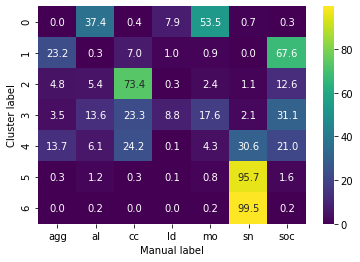

In [ ]:
ax=sns.heatmap(stats_tab_norm, annot=True, cmap='viridis', fmt='.1f')
plt.xlabel("Manual label")
plt.ylabel("Cluster label")
plt.savefig(FIGURES+datetime.datetime.today().strftime('%Y-%m-%d')+'_cluster_eval_'+clustering+'_'+tabletype+'sum')

In [ ]:
ax=sns.heatmap(stats_tab.astype(int), annot=True, cmap='viridis', fmt='d', cbar=False)
plt.xlabel("true label")
plt.ylabel("cluster label")
plt.savefig(FIGURES+datetime.datetime.today().strftime('%Y-%m-%d')+'_cluster_eval_HDBSCAN')

## Read in metadata

In [ ]:
sorted(list(set(umap_df['indv'])))
meerkat_info = pd.read_csv(PROJECT_PATH+'Meerkat_info.csv', sep=";")

In [ ]:
meerkat_info

Name            DOB     Code Dye mark Sex              Status
0   FLINT LOCKWOOD       27.10.16  VHMF001   H + TB   F            Dominant
1              PET       21.12.11  VCVM001   H + MB   M            Dominant
2            DANTE  27-29.12.2016  VHMM007  LS + LT   M  Eldest Subordinate
3       GUACAMOLE        01.09.17  VHMM008  SH + TB   M               Adult
4     DOUBLE FLUFF       01.09.17  VHMF010  SH + LT   F  Eldest Subordinate
5            TWIRL       15.05.18  VHMM014  LS + TB   M            Yearling
6        MOZARELLA       15.05.18  VHMF015  RT + TB   F            Yearling
7     OSCAR JUNIOR       15.05.18  VHMM016  LT + TB   M            Yearling
8            PINGU       15.05.18  VHMM017  RS + TB   M            Yearling
9         MUNCHKIN       26.09.18  VHMF019  MB + TB   F            Subadult
10        SHAMROCK       26.09.18  VHMM021  MB + LT   M            Subadult
11             ACE       26.09.18  VHMF022  MB + RS   F            Subadult
12          SHANDY       26.09.18  VHMM023  MB + LS   M            Subadult
13      DARJEELING       08.02.19  VHMF029       TB   F            Juvenile
14          SENCHA       08.02.19  VHMF030       RT   F            Juvenile
15          KAJESS       08.02.19  VHMF031       LT   F            Juvenile
16       BELPHEGOR       08.02.19  VHMM032       RS   M            Juvenile
17            MUGI       08.02.19  VHMM033       LS   M            Juvenile

In [ ]:
meerkat_names = meerkat_info['Code']

labelsep = re.compile('[\+\s]') # Match +
meerkat_dyemarks = [labelsep.sub('', i) for i in list(meerkat_info['Dye mark'])]
meerkat_info['Dye mark'] = meerkat_dyemarks


meerkat_dict = meerkat_info.drop(columns=['Code', 'Name']).T
meerkat_dict.columns = meerkat_names
meerkat_dict = meerkat_dict.to_dict()

In [ ]:
for ind in sorted(list(set(umap_df['indv']))):
  if (not ind in meerkat_dict.keys()):
    if ind in meerkat_dyemarks:
      ind_row = meerkat_info[meerkat_info['Dye mark']== ind]
      ind_code = meerkat_info[meerkat_info['Dye mark'] == ind].Code.values[0]
      if(ind_code in meerkat_dict.keys()):
      #  meerkat_dict[ind] = meerkat_dict[ind_code]
        print(ind, "appears to be ", ind_code) # this is sometimes wrong!
    else:
      print(ind, "not in dyemarks")

HMB appears to be  VCVM001
HRT not in dyemarks
HTB appears to be  VHMF001
LT appears to be  VHMF031
PET not in dyemarks
RT appears to be  VHMF030
VHMM002 not in dyemarks
VHMM003 not in dyemarks
VLF206 not in dyemarks


In [ ]:
meerkat_dict['HMB'] = meerkat_dict['VCVM001']
meerkat_dict['HTB'] = meerkat_dict['VHMF001']
meerkat_dict['LT'] = meerkat_dict['VHMM007'] # Ari told me this and it's in "audio_labeling_summary.xlsx"


#meerkat_dict['RT'] = meerkat_dict['VHMM006'] # COSMO, Ari told me this. VHMM006 is not in the file though!!! But I don't know his age/sex etc. 
                                             # I can find DOB in "GroupMarkJune2017.xls" and I guess it's a male. 
meerkat_dict['RT'] = {'DOB': '28.12.2016', 
                          'Dye mark': 'RT', 
                          'Sex': 'M', 
                          'Status': 'Adult'
                          }                                            

In [ ]:
meerkat_dict['HTB']

{'DOB': '27.10.16', 'Dye mark': 'HTB', 'Sex': 'F', 'Status': 'Dominant'}

Remaining:

- HRT not in dyemarks
- PET not in dyemarks
- VHMM002 not in dyemarks
- VHMM003 not in dyemarks
- VLF206 not in dyemarks

PET is a name and has code VCVM001 :

In [ ]:
meerkat_dict['PET'] = meerkat_dict['VCVM001']

VLF206 info can be found in add. excel:

In [ ]:
meerkat_dict['VLF206'] = {'DOB': '21.08.2013', 
                          'Dye mark': 'RCRSTBL', 
                          'Sex': 'F', 
                          'Status': 'Adult'
                          }

VHMM002 and VHMM003 can be found in additional excel sheets. Status and birth are just guesses. HRT is VHMM002.

In [ ]:
meerkat_dict['VHMM002'] = {'DOB': '27.10.16', 
                          'Dye mark': 'HRT', 
                          'Sex': 'M', 
                          'Status': 'Subordinate'
                          }

meerkat_dict['VHMM003'] = {'DOB': '27.10.16', 
                          'Dye mark': 'HLT', 
                          'Sex': 'M', 
                          'Status': 'Adult'
                          }

meerkat_dict['HRT'] = meerkat_dict['VHMM002'] 

Remainders will be set to "unknown"

In [ ]:
for ind in sorted(list(set(umap_df['indv']))):
  if (not ind in meerkat_dict.keys()):
    meerkat_dict[ind] = {'DOB': 'unknown', 
                         'Dye mark': 'unknown', 
                         'Sex': 'unknown', 
                         'Status':'unknown'}

In [ ]:
meerkat_dict

{'HMB': {'DOB': '21.12.11',
  'Dye mark': 'HMB',
  'Sex': 'M',
  'Status': 'Dominant'},
 'HRT': {'DOB': '27.10.16',
  'Dye mark': 'HRT',
  'Sex': 'M',
  'Status': 'Subordinate'},
 'HTB': {'DOB': '27.10.16',
  'Dye mark': 'HTB',
  'Sex': 'F',
  'Status': 'Dominant'},
 'LT': {'DOB': '27-29.12.2016',
  'Dye mark': 'LSLT',
  'Sex': 'M',
  'Status': 'Eldest Subordinate'},
 'PET': {'DOB': '21.12.11',
  'Dye mark': 'HMB',
  'Sex': 'M',
  'Status': 'Dominant'},
 'RT': {'DOB': '28.12.2016', 'Dye mark': 'RT', 'Sex': 'M', 'Status': 'Adult'},
 'VCVM001': {'DOB': '21.12.11',
  'Dye mark': 'HMB',
  'Sex': 'M',
  'Status': 'Dominant'},
 'VHMF001': {'DOB': '27.10.16',
  'Dye mark': 'HTB',
  'Sex': 'F',
  'Status': 'Dominant'},
 'VHMF010': {'DOB': '01.09.17',
  'Dye mark': 'SHLT',
  'Sex': 'F',
  'Status': 'Eldest Subordinate'},
 'VHMF015': {'DOB': '15.05.18',
  'Dye mark': 'RTTB',
  'Sex': 'F',
  'Status': 'Yearling'},
 'VHMF019': {'DOB': '26.09.18',
  'Dye mark': 'MBTB',
  'Sex': 'F',
  'Status': 'Su

## Adding metadata columns

In [ ]:
sex = [meerkat_dict[ind]['Sex'] for ind in umap_df['indv']]
umap_df['Sex'] = sex

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
status = [meerkat_dict[ind]['Status'] for ind in umap_df['indv']]
umap_df['status'] = status

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Now solve the tricky situation with VHMF001 / HTB, who was a subordinate in 2017, but dominant in 2019.

In [ ]:
print(meerkat_dict['HTB'])
print(meerkat_dict['VHMF001'])

{'DOB': '27.10.16', 'Dye mark': 'HTB', 'Sex': 'F', 'Status': 'Dominant'}
{'DOB': '27.10.16', 'Dye mark': 'HTB', 'Sex': 'F', 'Status': 'Dominant'}


For now, all are labeled as dominant. So, have to select those rows of HTB or VHMF001 that were recorded in 2017 and change status to 2017 there.

In [ ]:
umap_df.head(3)

Name        Start  Duration  ... nonfocal_yn Sex    status
1598  ALARM  1:10:56.215  0:00.178  ...           n   M  Dominant
1599  ALARM  1:12:04.643  0:00.317  ...           n   M  Dominant
1600  ALARM  1:12:15.132  0:00.192  ...           n   M  Dominant

[3 rows x 37 columns]

In [ ]:
# extract date 
year = [str.split(x, sep='-')[0] for x in umap_df['date']]
umap_df['year'] = year

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
umap_df.loc[(umap_df['indv'] == 'VHMF001') & (umap_df['year'] == '2017')]

Name        Start  Duration Time Format  ... nonfocal_yn Sex    status  year
24447   SN  1:09:47.294  0:00.059     decimal  ...           n   F  Dominant  2017
24448   SN  1:09:47.995  0:00.053     decimal  ...           n   F  Dominant  2017
24450   LD  1:09:49.484  0:00.172     decimal  ...           n   F  Dominant  2017
24451   LD  1:09:49.999  0:00.216     decimal  ...           n   F  Dominant  2017
24452   LD  1:09:50.840  0:00.303     decimal  ...           n   F  Dominant  2017
...    ...          ...       ...         ...  ...         ...  ..       ...   ...
24627   CC  1:21:51.500  0:00.144     decimal  ...           n   F  Dominant  2017
24824   CC  1:57:38.836  0:00.167     decimal  ...           n   F  Dominant  2017
24418   CC  1:02:02.035  0:00.172     decimal  ...           n   F  Dominant  2017
24836   CC  1:58:48.915  0:00.152     decimal  ...           n   F  Dominant  2017
24436   CC  1:06:27.618  0:00.121     decimal  ...           n   F  Dominant  2017

[161 rows x 38 columns]

In [ ]:
umap_df.loc[(umap_df['indv'] == 'VHMF001') & (umap_df['year'] == '2017'),'status'] = 'Subordinate'

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
umap_df.loc[(umap_df['indv'] == 'VHMF001') & (umap_df['year'] == '2017')]

Name        Start  Duration  ... Sex       status  year
24447   SN  1:09:47.294  0:00.059  ...   F  Subordinate  2017
24448   SN  1:09:47.995  0:00.053  ...   F  Subordinate  2017
24450   LD  1:09:49.484  0:00.172  ...   F  Subordinate  2017
24451   LD  1:09:49.999  0:00.216  ...   F  Subordinate  2017
24452   LD  1:09:50.840  0:00.303  ...   F  Subordinate  2017
...    ...          ...       ...  ...  ..          ...   ...
24627   CC  1:21:51.500  0:00.144  ...   F  Subordinate  2017
24824   CC  1:57:38.836  0:00.167  ...   F  Subordinate  2017
24418   CC  1:02:02.035  0:00.172  ...   F  Subordinate  2017
24836   CC  1:58:48.915  0:00.152  ...   F  Subordinate  2017
24436   CC  1:06:27.618  0:00.121  ...   F  Subordinate  2017

[161 rows x 38 columns]

## Test

In [ ]:
np.arange(-1,14,1)

array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13])

Compare each cluster against full dataset: (Enrichment fo sex or status?)

In [ ]:
from scipy.stats import chisquare
from scipy import stats

clusterlabels = np.arange(-1,14,1) #[0,1,2,3,4,5,6]

# find geometric median for each cluster
for label in clusterlabels:
  
  for var in ['Sex', 'status']:
    data = umap_df.loc[umap_df[var]!='NA'].copy()
    in_cluster = [1 if x==label else 0 for x in data[clustering]]
  
    data['in_cluster'] = in_cluster
  
    data_crosstab = pd.crosstab(data['in_cluster'],
                                data[var],
                                margins = False) 

    if (stats.chi2_contingency(data_crosstab)[1] < 0.05):
      print("Sig. ", var, " diff for cluster ", label)
      print(data_crosstab)



Sig.  Sex  diff for cluster  -1
Sex            F     M  unknown
in_cluster                     
0           1625  1568      166
1           1972  1172      184
Sig.  status  diff for cluster  -1
status      Adult  Dominant  Eldest Subordinate  ...  Subadult  Yearling  unknown
in_cluster                                       ...                             
0             424      1356                 113  ...       439       399      166
1             470      1026                 106  ...       326       471      184

[2 rows x 7 columns]
Sig.  Sex  diff for cluster  0
Sex            F     M  unknown
in_cluster                     
0           3486  2619      349
1            111   121        1
Sig.  status  diff for cluster  0
status      Adult  Dominant  Eldest Subordinate  ...  Subadult  Yearling  unknown
in_cluster                                       ...                             
0             847      2376                 215  ...       598       863      349
1              4

## Visualization

In [ ]:
distinct_20 = ['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4', '#46f0f0', 
               '#f032e6', '#bcf60c', '#fabebe', '#008080', '#e6beff', '#9a6324', '#fffac8', 
               '#800000', '#aaffc3', '#808000', '#ffd8b1', '#000075', '#808080', '#ffffff', '#000000']

### Distribution

#### Categorical variables

Figure that shows frequencies of **categorical** variables in different groups.
Set groups and variable of interest with 
- group_var = [name_of_grouping_variable] 
- var [categorical_variable_of_interest]

In [ ]:
var = 'status'
var = 'Sex'
#var = 'date'
#var = 'indv'
#var = 'soundfoc_yn'
group_var = 'call_lable'
group_var = 'HDBSCAN'

#var_levels = sorted(list(set(umap_df[var])))
#group_var_levels =  sorted(list(set(umap_df[group_var])))
truth = 'call_lable'

#plt.figure(figsize=(10, 20))
plt.figure(figsize=(12, 10))

my_df = umap_df.loc[umap_df[var]!='NA']
#my_df = my_df.loc[my_df[group_var]!=-1] # for HDBSCAN
var_levels = sorted(list(set(my_df[var])))
group_var_levels =  sorted(list(set(my_df[group_var])))

for i,group_var_level in enumerate(group_var_levels,1):
    #plt.subplot(5, 3, i)
    plt.subplot(5, 4, i)
    sub_df = my_df.loc[my_df[group_var]==group_var_level]

    labelcounts = pd.DataFrame(sub_df[var].value_counts())

    for level in var_levels:
      if (not level in labelcounts.index):
        row = pd.Series({var:0},name=level)
        labelcounts = labelcounts.append(row)


    labelcounts.sort_index(inplace=True)
    pal = sns.color_palette(distinct_20, n_colors=len(labelcounts.index))  
    #pal = sns.color_palette("Set2", n_colors=len(labelcounts.index))
    plt.barh(labelcounts.index, labelcounts[var].values, color = pal)

    for index, value in enumerate(labelcounts[var].values):
      plt.text(value, index, str(value))
    title = str(group_var_level)+" ("+str(sub_df.shape[0])+")"
    if group_var!=truth:
      title = str(group_var_level)+" ("+str(sub_df.shape[0])+", "+cluster_to_truth[group_var_level]+")"
    plt.title(title)
    plt.ylabel(var)
    plt.xlabel('Frequencies')

# Add plot for all
#plt.subplot(5, 3, i+1)
plt.subplot(5, 4, i+1)
sub_df = my_df

#labelcounts = pd.DataFrame(sub_df[var].value_counts())
labelcounts = pd.DataFrame(umap_df[var].value_counts())
labelcounts.sort_index(inplace=True)

plt.barh(labelcounts.index, labelcounts[var].values, color = pal)

for index, value in enumerate(labelcounts[var].values):
  plt.text(value, index, str(value))

#title='All ('+str(my_df.shape[0])+")"
title='All ('+str(umap_df.shape[0])+")"
plt.title(title)
plt.ylabel(var)
plt.xlabel('Frequencies')

plt.tight_layout()
plt.savefig(FIGURES+'cluster_analysis_'+group_var+'_'+var+'.png')

In [ ]:
2382/6687

0.35621354867653654

In [ ]:
sorted(list(set(umap_df['date'])))

['2017-08-03',
 '2017-08-06',
 '2017-08-07',
 '2017-08-23',
 '2017-08-24',
 '2017-08-25',
 '2017-09-03',
 '2017-09-04',
 '2017-09-05',
 '2019-07-12',
 '2019-07-13',
 '2019-07-14',
 '2019-07-15',
 '2019-07-16',
 '2019-07-17']

#### Continuous variables

Figure that shows distribution of **continuous** variables in different groups.
Set groups and variable of interest with 
- group_var = [name_of_grouping_variable] 
- var [continuous_variable_of_interest]


In [ ]:
var = 'duration_s'
group_var = 'call_lable'
group_var = 'Aggl_Euclid'

group_var_levels =  sorted(list(set(umap_df[group_var])))

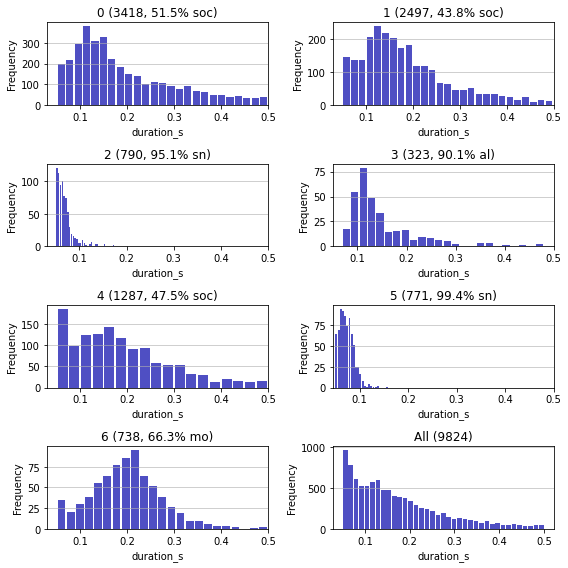

In [ ]:
plt.figure(figsize=(8, 8))

xmax = np.max(umap_df[var].values)

for i,group_var_level in enumerate(group_var_levels,1):
    plt.subplot(4, 2, i)
    sub_df = umap_df.loc[umap_df[group_var]==group_var_level]

    n, bins, patches = plt.hist(x=sub_df[var], bins='auto', color='#0504aa',
                            alpha=0.7, rwidth=0.85)
    plt.grid(axis='y', alpha=0.75)

    title = str(group_var_level)+" ("+str(sub_df.shape[0])+")"
    if group_var!=truth:
      title = str(group_var_level)+" ("+str(sub_df.shape[0])+", "+cluster_to_truth[group_var_level]+")"
 
    plt.xlim(xmax=xmax)
    plt.title(title)
    plt.ylabel('Frequency')
    plt.xlabel(var)

# Add plot for al
plt.subplot(4, 2, i+1)
sub_df = umap_df

n, bins, patches = plt.hist(x=sub_df[var], bins='auto', color='#0504aa',
                            alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)

title = 'All ('+str(sub_df.shape[0])+")"
plt.title(title)
plt.ylabel('Frequency')
plt.xlabel(var)

plt.tight_layout()

### Overrepresentation

#### Categorical variables

In [ ]:
var = 'status'
#var = 'Sex'
#var = 'soundfoc_yn'
group_var = 'call_lable'
#group_var = 'Aggl_Euclid'
group_var = 'HDBSCAN'
truth = 'call_lable'

In [ ]:
umap_df.head(2)

Name        Start  Duration  ... certain_yn index_id nonfocal_yn
1598  ALARM  1:10:56.215  0:00.178  ...          y     1598           n
1599  ALARM  1:12:04.643  0:00.317  ...          y     1599           n

[2 rows x 35 columns]

In [ ]:
plt.figure(figsize=(10, 10))

# Remove NA
my_df = umap_df.loc[umap_df[var]!='NA']
my_df = my_df.loc[umap_df[group_var]!=-1]
var_levels = sorted(list(set(my_df[var])))
group_var_levels =  sorted(list(set(my_df[group_var])))

labelcounts_all = pd.DataFrame(my_df[var].value_counts(normalize=True))
labelcounts_all.sort_index(inplace=True)

for i,group_var_level in enumerate(group_var_levels,1):
  plt.subplot(5, 3, i)
  sub_df = my_df.loc[my_df[group_var]==group_var_level]
  

  labelcounts = pd.DataFrame(sub_df[var].value_counts(normalize=True))

  missing_level = []

  for i,level in enumerate(var_levels):
    if (not level in labelcounts.index):
      missing_level.append(True)
      row = pd.Series({var:100/(sub_df.shape[0])},name=level) # equi to 1 meerkat
      row = pd.Series({var:1},name=level)
      labelcounts = labelcounts.append(row)
    else:
      missing_level.append(False)
  
  labelcounts.sort_index(inplace=True)
  #pal = sns.color_palette("Set2", n_colors=len(labelcounts.index))
  y = np.log2(labelcounts[var].values/labelcounts_all[var].values)
  # log of 0 problem! thus, set missing levels to % equivalent to 1 meerkat
  
  c = ["red" if x<=0 else "green" for x in y]
  xmin = -5
  xmax = 5
  for i,missing in enumerate(missing_level):
    if(missing):
      c[i] = "red"
      y[i] = xmin
      labelcounts.iloc[i,0] = 0


  plt.barh(labelcounts.index, y, color = c)
  #plt.barh(labelcounts.index, y, color = pal)
  #plt.bar(labelcounts.index, y, color = pal)
  plt.axvline(x=0, color="black", linewidth=1,linestyle=':')


  for index, (value1,value2,y) in enumerate(zip(labelcounts[var].values, labelcounts_all[var].values,y)):
     #plt.text(y, index, (str(round(value1*100,1))+"% ("+str(round(value2*100,1))+"%)"))
     plt.text(xmax, index, (str(int(value1*100))+"% ("+str(int(value2*100))+")"))

  title = str(group_var_level)+" ("+str(sub_df.shape[0])+")"
  if group_var!=truth:
    title = str(group_var_level)+" ("+str(sub_df.shape[0])+", "+cluster_to_truth[group_var_level]+")"
  plt.title(title)
  
  plt.ylabel(var)
  plt.xlabel('log2 fold enrichment')
  plt.xlim(-5,5)

plt.tight_layout()

# Example specs

Example spectrograms for all clusters

In [ ]:
n_specs=5
specs = {}
  
plt.figure(figsize=(15, 28))

clusters = sorted(list(set(umap_df.HDBSCAN.values)))
k=1

for cluster in clusters:
  example = umap_df[umap_df['HDBSCAN']==cluster].sample(n = n_specs, random_state=2204)
  specs = example['denoised_spectrograms'].values
  labels = example['call_lable'].values
  i=0 
  for spec, label in zip(specs, labels):
    plt.subplot(len(clusters), n_specs, k)
    plt.imshow(spec, interpolation='nearest', aspect='equal')
    plt.axis('off')
    if i==0:     
      title = str(cluster)
      plt.title(title, loc='left')
      title = str(label)
      plt.title(title)
    else:
      title = str(label)
      plt.title(title)
    
    #title = str(cluster)+" ("+str(label)+")"
    #title = str(label)
    k += 1
    i+=1
plt.tight_layout()
plt.savefig(FIGURES+'HDBSCAN_cluster_examples.png')

Example spectrograms for all call types

In [ ]:
df_name = 'embedding_denoised_stretched_mfcc_delta_balanced'
df = pd.read_pickle(DATA+df_name)

In [ ]:
calltypes = sorted(list(set(df['call_lable'])))

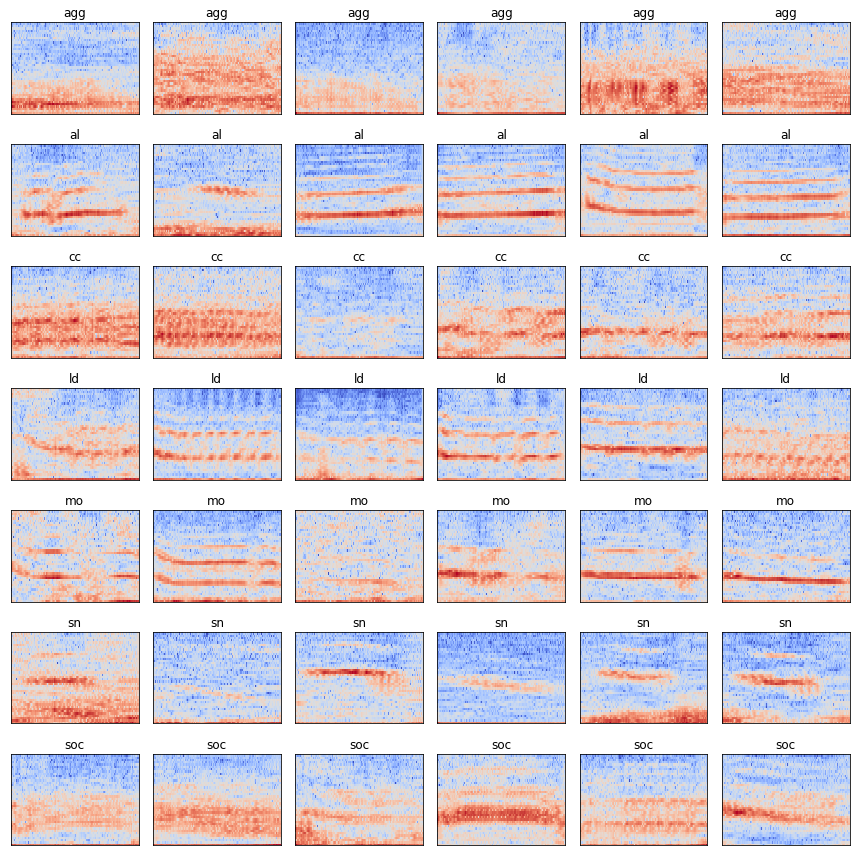

In [ ]:
n_specs=6

specs = {}
for calltype in calltypes:
  example = df[df['call_lable']==calltype].sample(n = n_specs)
  specs[calltype] = example['denoised_stretched_spectrograms'].values
  
plt.figure(figsize=(12, 12))
k=1

for calltype in calltypes:
  calltype_specs = specs[calltype]
  for i in range(n_specs):
    spec = calltype_specs[i]
    plt.subplot(len(calltypes), n_specs, k)
    librosa.display.specshow(spec)
    title = calltype
    plt.title(title)
    k += 1
plt.tight_layout()

In [ ]:
audios = []
for calltype in calltypes:
  example = df[df['call_lable']==calltype].sample(n = 1)
  arr = example['raw_audio'].values
  audios.append(arr[0])

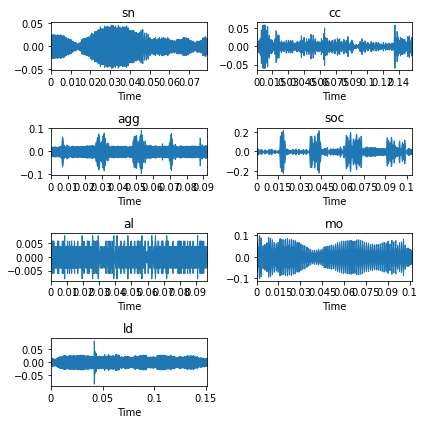

In [ ]:
plt.figure(figsize=(6, 6))
for i,syll in enumerate(audios,1):
  plt.subplot(4, 2, i)
  #librosa.display.specshow(spec)
  librosa.display.waveplot(syll, sr=8000)
  #plt.colorbar(format='%+2.0f dB')
  plt.title(calltypes[i-1])
plt.tight_layout()

In [ ]:
df.columns

Index(['duration_s', 'samplerate_hz', 'indv', 'original_wav', 'bout_number',
       'call_lable', 'raw_audio', 'spectrograms', 'mfccs', 'mfcc_deltas',
       'mfcc_deltadeltas', 'soundfoc_yn', 'stretched_spectrograms',
       'stretched_mfccs', 'stretched_mfcc_deltas',
       'stretched_mfcc_deltadeltas', 'denoised_spectrograms',
       'denoised_stretched_spectrograms', 'denoised_mfccs',
       'denoised_stretched_mfccs', 'denoised_mfcc_deltas',
       'denoised_stretched_mfcc_deltas', 'UMAP1', 'UMAP2', 'Sex', 'status',
       'HDBSCAN', 'KMeans', 'Aggl_Euclid'],
      dtype='object')

In [ ]:
n_ex = 4

spectr_type = 'denoised_spectrograms'
labeltype = 'call_lable'
labeltype = 'HDBSCAN'

calltypes = sorted(list(set(df[labeltype])))
n_labels = len(calltypes)

plt.figure(figsize=(8, 8))
i=1
for calltype in calltypes:
  example = df[df[labeltype]==calltype].sample(n = n_ex)
  specs = example[spectr_type].values
  for spec in specs:
    plt.subplot(n_labels, n_ex, i)
    librosa.display.specshow(spec)
    #plt.colorbar(format='%+2.0f dB')
    if (labeltype!='call_lable'):
      try:
        title = str(calltype)+" ("+cluster_to_truth[calltype]+")"
      except NameError:
        title = calltype
    else:
      title = calltype
    plt.title(title)
    i=i+1
plt.tight_layout()
plt.savefig(FIGURES+spectr_type+labeltype+'_examples.png')

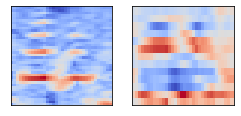

In [ ]:

example = df[df[labeltype]==calltype].sample(n = 1)
plt.figure(figsize=(4, 4))
plt.subplot(2, 2, 1)
librosa.display.specshow(example['denoised_spectrograms'].values[0])
plt.subplot(2, 2, 2)
librosa.display.specshow(example['denoised_mfccs'].values[0])

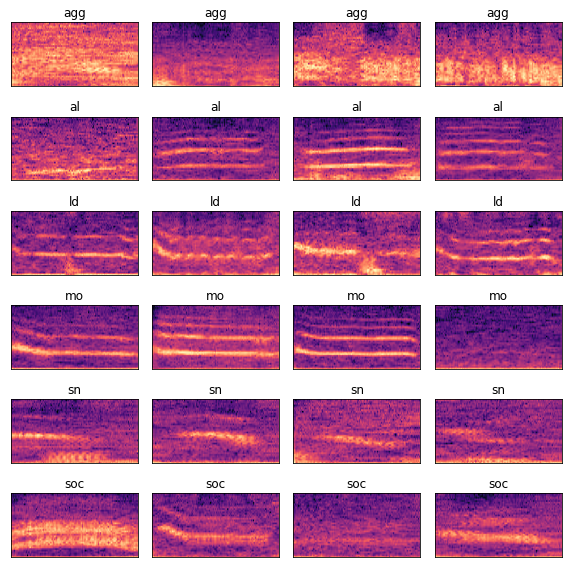

In [ ]:
#from VAE

n_ex = 4

calltypes = sorted(list(set(y_train)))
n_labels = len(calltypes)
label_arr = y_train
labletype = 'truth'

plt.figure(figsize=(8, 8))
i=1
for calltype in calltypes:
  call_indices = np.where(label_arr==calltype)[0]
  index = np.random.choice(call_indices.shape[0], n_ex, replace=False)
  examples = call_indices[index]
  example_imgs = X_train[examples,:,:]
  myspecs = []
  for j in range(examples.shape[0]):
    myspecs.append(example_imgs[j,:,:,0])

  for spec in myspecs:
    plt.subplot(n_labels, n_ex, i)
    librosa.display.specshow(spec)
    #plt.colorbar(format='%+2.0f dB')
    if (labeltype!='truth'):
      try:
        title = str(calltype)+" ("+cluster_to_truth[calltype]+")"
      except NameError:
        title = calltype
    else:
      title = calltype
    plt.title(title)
    i=i+1
plt.tight_layout()
#plt.savefig(FIGURES+spectr_type+labeltype+'_examples.png')



# Check RAM

In [ ]:
def sizeof_fmt(num, suffix='B'):
    ''' by Fred Cirera,  https://stackoverflow.com/a/1094933/1870254, modified'''
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f %s%s" % (num, 'Yi', suffix)

for name, size in sorted(((name, sys.getsizeof(value)) for name, value in locals().items()),
                         key= lambda x: -x[1])[:10]:
    print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))

                     specs_arr: 425.7 MiB
                          data: 425.7 MiB
                     embedding: 307.0 MiB
                        result: 307.0 MiB
                       sub_emb: 109.3 MiB
                        df_all: 56.0 MiB
                  spectrograms: 23.4 MiB
                raw_audio_data:  3.1 MiB
                          _273: 613.3 KiB
                    lablenames: 397.0 KiB


# Check ARI function

In [ ]:
df = pd.read_pickle(DATA+'df_denoised_balanced')
umap_df = df[df.nonfocal_yn == 'n'] # for focal
cluster_umap = pd.read_pickle(DATA+'cluster_umap_mod')
true_labels = umap_df.call_lable.values
truth = 'call_lable'

embedding_filename = '2020-10-14_embedding_denoised_melspectro_focal'
embedding = pd.read_pickle(DATA+embedding_filename)
embedding = embedding.iloc[:,0:5] # because 5-dim is enough

for x in ['kmeans', 'agglo', 'GMM', 'HDBSCAN']:
  umap_df[x] = cluster_umap[x]

In [ ]:
clustering = 'HDBSCAN'
HDBSCAN_labels = np.asarray(umap_df[clustering])
unassigned = np.zeros(len(HDBSCAN_labels))
unassigned[np.where(HDBSCAN_labels==-1)[0]] = 1
assigned = [False if x==1 else True for x in unassigned]

HDB_true_labels = true_labels[assigned]
HDB_pred_labels = HDBSCAN_labels[assigned]
embedding_assigned = embedding.loc[assigned,:]

In [ ]:
labels_true = HDB_true_labels
labels_pred = HDB_pred_labels
n_samples = labels_true.shape[0]
n_classes = np.unique(labels_true).shape[0]
n_clusters = np.unique(labels_pred).shape[0]

In [ ]:
print(n_samples)
print(n_classes)
print(n_clusters)

3359
7
14


In [ ]:
from scipy import sparse as sp
from scipy.special import comb

In [ ]:
def contingency_matrix(labels_true, labels_pred, *, eps=None, sparse=False):
    """Build a contingency matrix describing the relationship between labels.
    Parameters
    ----------
    labels_true : int array, shape = [n_samples]
        Ground truth class labels to be used as a reference
    labels_pred : array-like of shape (n_samples,)
        Cluster labels to evaluate
    eps : None or float, optional.
        If a float, that value is added to all values in the contingency
        matrix. This helps to stop NaN propagation.
        If ``None``, nothing is adjusted.
    sparse : boolean, optional.
        If True, return a sparse CSR continency matrix. If ``eps is not None``,
        and ``sparse is True``, will throw ValueError.
        .. versionadded:: 0.18
    Returns
    -------
    contingency : {array-like, sparse}, shape=[n_classes_true, n_classes_pred]
        Matrix :math:`C` such that :math:`C_{i, j}` is the number of samples in
        true class :math:`i` and in predicted class :math:`j`. If
        ``eps is None``, the dtype of this array will be integer. If ``eps`` is
        given, the dtype will be float.
        Will be a ``scipy.sparse.csr_matrix`` if ``sparse=True``.
    """

    if eps is not None and sparse:
        raise ValueError("Cannot set 'eps' when sparse=True")

    classes, class_idx = np.unique(labels_true, return_inverse=True)
    clusters, cluster_idx = np.unique(labels_pred, return_inverse=True)
    n_classes = classes.shape[0]
    n_clusters = clusters.shape[0]
    # Using coo_matrix to accelerate simple histogram calculation,
    # i.e. bins are consecutive integers
    # Currently, coo_matrix is faster than histogram2d for simple cases
    contingency = sp.coo_matrix((np.ones(class_idx.shape[0]),
                                 (class_idx, cluster_idx)),
                                shape=(n_classes, n_clusters),
                                dtype=np.int)
    if sparse:
        contingency = contingency.tocsr()
        contingency.sum_duplicates()
    else:
        contingency = contingency.toarray()
        if eps is not None:
            # don't use += as contingency is integer
            contingency = contingency + eps
    return contingency

def _comb2(n):
    # the exact version is faster for k == 2: use it by default globally in
    # this module instead of the float approximate variant
    return comb(n, 2, exact=1)

In [ ]:
contingency = contingency_matrix(labels_true, labels_pred, sparse=True)

In [ ]:
contingency.data

array([ 13,  12, 133,  16,  46,   1,   1,   1, 230,  82,   7,  12,   1,
        10,   2,   3,   8,  14,   2,  62,  17,  24,  71, 127, 289,  42,
         1,   4,   8,  29,   2,   1,   1,   3,  16,  98, 135,   1, 104,
         4,   6,   3,   9,   1,   9,   2, 624,   3,   1,  15,   1, 157,
       179, 108,  29,   1,   1,  51, 270,  96,  19,  82,  35,  24],
      dtype=int64)

In [ ]:
sum_comb_c = sum(_comb2(n_c) for n_c in np.ravel(contingency.sum(axis=1)))
sum_comb_k = sum(_comb2(n_k) for n_k in np.ravel(contingency.sum(axis=0)))
sum_comb = sum(_comb2(n_ij) for n_ij in contingency.data)

In [ ]:
np.ravel(contingency.sum(axis=1))

array([ 223,  371,  632,   46,  380, 1099,  608])

In [ ]:
prod_comb = (sum_comb_c * sum_comb_k) / _comb2(n_samples)
mean_comb = (sum_comb_k + sum_comb_c) / 2.

(sum_comb - prod_comb) / (mean_comb - prod_comb)

0.3911735897443698